In [376]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import hashlib
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [377]:
def anonymize_dates(df):
    """Anonymize dates using DBSCAN clustering and central time calculation."""
    def process_week_year(week_year_df):
        # Convert timestamps to numerical values (Unix time)
        week_year_df["Timestamp"] = week_year_df["Date"].astype(int) / 10**9  # Convert to seconds

        # Apply DBSCAN clustering
        eps = 3600  # 1 hour (in seconds)
        min_samples = 2  # At least 2 points to form a cluster
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(week_year_df[["Timestamp"]])
        week_year_df["Cluster"] = clustering.labels_

        # Function to calculate central time for a cluster (POI-preserving)
        def calculate_central_time(cluster_group):
            if len(cluster_group) == 0:
                return pd.NaT  # Handle empty clusters

            # Use the median timestamp (more robust to outliers)
            central_time = cluster_group.median()

            # Ensure the central time is within the same week and year as the original timestamps
            start_of_week = cluster_group.min() - timedelta(days=cluster_group.min().weekday())
            end_of_week = start_of_week + timedelta(days=6, hours=23, minutes=59, seconds=59)

            if central_time < start_of_week:
                central_time = start_of_week
            elif central_time > end_of_week:
                central_time = end_of_week

            return central_time

        # Group by cluster and calculate central time
        cluster_central_times = week_year_df.groupby("Cluster")["Date"].apply(calculate_central_time)

        # Replace timestamps with central time
        week_year_df["AnonDate"] = week_year_df["Cluster"].map(cluster_central_times)

        return week_year_df

    # Group by week and year, and process each week-year's data
    df = df.groupby(["Year", "Week"], group_keys=False).apply(process_week_year).reset_index(drop=True)

    return df

In [378]:
def anonymize_ids(df):
    """Anonymize IDs using a hash function."""
    def hash_id(row):
        raw = f"{row['ID']}.{row['Year']}-{row['Week']}"
        return hashlib.md5(raw.encode()).hexdigest()[:8]

    df["AnonID"] = df.apply(hash_id, axis=1)
    return df

In [421]:
def add_dp_noise(value, epsilon, sensitivity):
    """
    Add Laplace noise to a value for differential privacy.
    
    Parameters:
        value (float): The original value (latitude or longitude).
        epsilon (float): Privacy budget.
        sensitivity (float): Sensitivity of the data.
    
    Returns:
        float: Anonymized value with Laplace noise.
    """
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

In [380]:
def anonymize_locations(df, gps_epsilon=1.0, sensitivity_km=1/111):
    """
    Anonymize GPS coordinates in a DataFrame using Laplace noise.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'Latitude' and 'Longitude' columns.
        gps_epsilon (float): Privacy budget for differential privacy.
        sensitivity_km (float): Sensitivity for GPS data in kilometers.
    
    Returns:
        pd.DataFrame: DataFrame with anonymized 'AnonLatitude' and 'AnonLongitude'.
    """
    df["AnonLatitude"] = df["Latitude"].apply(
        lambda lat: round(add_dp_noise(lat, gps_epsilon, sensitivity_km), 2)
    )
    df["AnonLongitude"] = df["Longitude"].apply(
        lambda lon: round(add_dp_noise(lon, gps_epsilon, sensitivity_km), 2)
    )
    return df

: 

: 

In [494]:
import hashlib
import random

def add_dp_noise_deterministic(value, epsilon, sensitivity, unique_key):
    """
    Add deterministic differential privacy noise based on a hash of the unique_key.
    The same `unique_key` will always produce the same noise.

    Parameters:
        value (float): Original value (latitude/longitude).
        epsilon (float): Privacy budget.
        sensitivity (float): Sensitivity of the data.
        unique_key (str): A unique identifier for deterministic noise (e.g., user ID + coordinates).

    Returns:
        float: Value with added deterministic noise.
    """
    # Hash the unique key
    hash_value = int(hashlib.sha256(unique_key.encode()).hexdigest(), 16)
    random.seed(hash_value)  # Set random seed based on the hash

    # Generate Laplace noise
    scale = sensitivity / epsilon
    noise = random.gauss(0, scale)  # Replace with `random.laplace()` if available
    return value + noise

In [495]:
import pandas as pd
import random
import numpy as np
from geopy.distance import geodesic
from collections import defaultdict
from datetime import timedelta

def determine_top_n_places(df, n=2, rounding_precision=5):
    """
    Determine the top `n` most popular places for each user based on time spent.

    Parameters:
        df (pd.DataFrame): DataFrame containing columns ['ID', 'Date', 'Latitude', 'Longitude'].
        n (int): Number of most popular places to identify.
        rounding_precision (int): Precision to round latitude and longitude for clustering.

    Returns:
        dict: A dictionary where keys are userIds and the values are lists of the top `n` places with time spent.
    """
    # Convert Date column to datetime format
    df["Date"] = pd.to_datetime(df["Date"], format="mixed")
    
    # Round latitude and longitude for clustering places
    df['Lat_rounded'] = df['Latitude'].round(rounding_precision)
    df['Long_rounded'] = df['Longitude'].round(rounding_precision)

    # Sort data by ID and Date to calculate time spent
    df = df.sort_values(by=['ID', 'Date'])

    # Dictionary to store results
    user_top_places = defaultdict(list)

    # Iterate over each user
    for user, user_data in df.groupby('ID'):
        # Calculate time spent at each rounded location
        time_spent = defaultdict(timedelta)
        prev_time = None
        prev_location = None

        for _, row in user_data.iterrows():
            current_time = row['Date']
            current_location = (row['Lat_rounded'], row['Long_rounded'])

            # If there's a previous location, calculate the time spent
            if prev_time is not None and prev_location is not None:
                duration = current_time - prev_time
                time_spent[prev_location] += duration

            # Update previous time and location
            prev_time = current_time
            prev_location = current_location

        # Get the top `n` places with the highest time spent
        top_places = sorted(time_spent.items(), key=lambda x: x[1], reverse=True)[:n]
        user_top_places[user] = [{'location': loc, 'time_spent': duration} for loc, duration in top_places]

    return user_top_places

def mix_zone_anonymization(data, top_places, mix_zone_radius=3000):
    """
    Anonymize infrequent locations using the Mix Zones approach.

    Parameters:
        data (pd.DataFrame): Input data with columns ['ID', 'Latitude', 'Longitude'].
        top_places (dict): Dictionary of top n frequent places for each user (from determine_top_n_places).
        mix_zone_radius (float): Radius of the mix zone in meters.
        noise_scale (float): Standard deviation for spatial noise (latitude/longitude degrees).

    Returns:
        pd.DataFrame: DataFrame with anonymized locations.
    """
    # Validate input
    if not all(col in data.columns for col in ['ID', 'Latitude', 'Longitude']):
        raise ValueError("Input DataFrame must contain columns: ['ID', 'Latitude', 'Longitude']")

    # Prepare a DataFrame of frequent locations
    frequent_locations = []
    for user, places in top_places.items():
        for place in places:
            frequent_locations.append({
                'ID': user,
                'Latitude': place['location'][0],
                'Longitude': place['location'][1]
            })
    frequent_locations_df = pd.DataFrame(frequent_locations)

    # List to store anonymized data
    anonymized_data = []


    for _, row in data.iterrows():
        user_id = row['ID']
        current_coords = (row['Latitude'], row['Longitude'])

        # Check if the current location is a frequent location
        user_frequent = frequent_locations_df[frequent_locations_df['ID'] == user_id]
        is_frequent = user_frequent.apply(
            lambda loc: geodesic(current_coords, (loc['Latitude'], loc['Longitude'])).meters <= mix_zone_radius,
            axis=1
        ).any()

        if is_frequent:
            # Deterministically anonymize the frequent location
            unique_key_lat = f"{user_id}_{current_coords[0]}_lat"
            unique_key_lon = f"{user_id}_{current_coords[1]}_lon"
            anonymized_coords = (
                add_dp_noise_deterministic(current_coords[0], epsilon=1.0, sensitivity=3/111, unique_key=unique_key_lat),
                add_dp_noise_deterministic(current_coords[1], epsilon=1.0, sensitivity=3/111, unique_key=unique_key_lon)
            )
        else:
            # Apply differential privacy noise to anonymize the infrequent location
            anonymized_coords = (
                add_dp_noise(current_coords[0], epsilon=1.0, sensitivity=1),  # Latitude
                add_dp_noise(current_coords[1], epsilon=1.0, sensitivity=1)   # Longitude
            )

        # Store the anonymized location
        anonymized_data.append({
            'OriginalIndex': row.name,  # Preserve the original index
            'AnonLatitude': anonymized_coords[0],
            'AnonLongitude': anonymized_coords[1]
        })

    anonymized_df = pd.DataFrame(anonymized_data)

    return anonymized_df

In [ ]:

import seaborn as sns

# Visualization function for per-person analysis
def visualize_poi_effectiveness_per_person(original_df, anonymized_df, poi_precision=2, top_n=5):
    """
    Visualize the effectiveness of anonymization for each person by comparing POI visit counts and time spent
    between original and anonymized datasets.

    Parameters:
        original_df (pd.DataFrame): Original dataset.
        anonymized_df (pd.DataFrame): Anonymized dataset.
        poi_precision (int): Precision for rounding GPS coordinates to define POIs.
        top_n (int): Number of top POIs to display.
    """
    # Round GPS coordinates to simulate POI aggregation
    original_df["POI"] = original_df.apply(lambda x: f"({round(x['Latitude'], poi_precision)}, {round(x['Longitude'], poi_precision)})", axis=1)
    anonymized_df["AnonPOI"] = anonymized_df.apply(lambda x: f"({round(x['AnonLatitude'], poi_precision)}, {round(x['AnonLongitude'], poi_precision)})", axis=1)
    
    # Group by individual (ID)
    original_grouped = original_df.groupby("ID")
    anonymized_grouped = anonymized_df.groupby("ID")

    # Iterate over each individual
    for person_id, original_person_data in original_grouped:
        anonymized_person_data = anonymized_grouped.get_group(person_id)

        # Calculate time spent at each POI for this person
        def calculate_time_spent(data, poi_col, date_col):
            data = data.sort_values(by=[poi_col, date_col])
            data['TimeDiff'] = data.groupby(poi_col)[date_col].diff().fillna(pd.Timedelta(seconds=0))
            return data.groupby(poi_col)['TimeDiff'].sum().reset_index()

        original_time_spent = calculate_time_spent(original_person_data, 'POI', 'Date')
        anonymized_time_spent = calculate_time_spent(anonymized_person_data, 'AnonPOI', 'AnonDate')

        # Merge time spent data
        original_time_spent.columns = ['POI', 'Original Time Spent']
        # print (original_time_spent)
        anonymized_time_spent.columns = ['POI', 'Anonymized Time Spent']
        # print(anonymized_time_spent)
        time_spent_comparison = pd.merge(original_time_spent, anonymized_time_spent, on='POI', how='outer').fillna(pd.Timedelta(seconds=0))
        # print(time_spent_comparison)

        # Convert time spent to seconds for easier comparison
        time_spent_comparison['Original Time Spent'] = time_spent_comparison['Original Time Spent'].dt.total_seconds()
        # print(time_spent_comparison['Original Time Spent'])
        time_spent_comparison['Anonymized Time Spent'] = time_spent_comparison['Anonymized Time Spent'].dt.total_seconds()
        # print(time_spent_comparison['Anonymized Time Spent'])

        # Sort by the highest time spent (either original or anonymized)
        time_spent_comparison['Max Time Spent'] = time_spent_comparison[['Original Time Spent', 'Anonymized Time Spent']].max(axis=1)
        time_spent_comparison = time_spent_comparison.sort_values(by='Max Time Spent', ascending=False)

        # Select the top `n` POIs
        top_pois = time_spent_comparison.head(top_n)

        # Debug: Print the top POIs
        # print("Top POIs:")
        # print(top_pois)

        # Melt the data for visualization
        melted_data = pd.melt(top_pois, id_vars=['POI'], value_vars=['Original Time Spent', 'Anonymized Time Spent'])

        # Plotting for this person
        plt.figure(figsize=(14, 6))
        plt.suptitle(f"POI Effectiveness for Person {person_id}", fontsize=16)

        # Bar plot for time spent
        plt.subplot(1, 2, 1)
        sns.barplot(x='POI', y='value', hue='variable', data=melted_data)
        plt.title(f'Top {top_n} POIs: Time Spent (Original vs Anonymized)')
        plt.xlabel('POI Locations')
        plt.ylabel('Time Spent (Seconds)')
        plt.xticks(rotation=45)
        plt.legend(title='Dataset')

        # Heatmap for effectiveness score
        plt.subplot(1, 2, 2)
        sns.heatmap(time_spent_comparison[['Original Time Spent', 'Anonymized Time Spent']].head(top_n), 
                    annot=True, fmt=".0f", cmap="Blues", cbar=True)
        plt.title('Time Spent Comparison (Top POIs)')
        plt.xlabel('Dataset')
        plt.ylabel('POI Locations')

        plt.tight_layout()
        plt.show()

In [ ]:
# Main anonymization process
def anonymize_data(input_file, output_file, gps_epsilon=1.0, sensitivity_km=1/111):
    # Load data
    df = pd.read_csv(input_file, delimiter="\t", names=["ID", "Date", "Latitude", "Longitude"])
    df["Date"] = pd.to_datetime(df["Date"])
    df["Week"] = df["Date"].dt.isocalendar().week
    df["Year"] = df["Date"].dt.isocalendar().year

    # Add an index column to preserve the original order
    df["OriginalIndex"] = df.index

    # Step 1: Anonymize IDs
    df = anonymize_ids(df)

    # Step 2: Anonymize Dates
    df = anonymize_dates(df)

    # Step 3: Anonymize Locations
    df = anonymize_locations(df, gps_epsilon, sensitivity_km)

    # Sort the DataFrame by the original index to preserve the order of lines
    df = df.sort_values(by="OriginalIndex").reset_index(drop=True)

    # Save the anonymized dataset
    anonymized_df = df[["AnonID", "AnonDate", "AnonLatitude", "AnonLongitude"]]
    poi_df = df[["ID", "AnonDate", "AnonLatitude", "AnonLongitude"]]
    # anonymized_df.columns = ["ID", "Date", "Latitude", "Longitude"]
    anonymized_df.to_csv(output_file, index=False, sep="\t", header=False)
    print(f"Improved anonymized data saved to {output_file}")

    # Visualize POI effectiveness
    # visualize_poi_effectiveness_per_person(df, poi_df)



In [496]:
def anonymize_data_2(input_file, output_file):
    # Load data
    df = pd.read_csv(input_file, delimiter="\t", names=["ID", "Date", "Latitude", "Longitude"])
    df["Date"] = pd.to_datetime(df["Date"])
    df["Week"] = df["Date"].dt.isocalendar().week
    df["Year"] = df["Date"].dt.isocalendar().year

    # Add an index column to preserve the original order
    df["OriginalIndex"] = df.index
    
    # Step 1: Anonymize IDs
    df = anonymize_ids(df)

    # Step 2: Anonymize Dates
    df = anonymize_dates(df)

    # Step 3: Determine Top n Places
    top_places = determine_top_n_places(df, n=3)

    # Step 4: Apply Mix Zone Anonymization
    anonymized_positions = mix_zone_anonymization(df, top_places)

    # Merge anonymized positions back into the dataset using the original index
    final_anonymized_data = df.merge(anonymized_positions, on="OriginalIndex", how="left")

    # Sort by the original index
    final_anonymized_data = final_anonymized_data.sort_values(by="OriginalIndex").reset_index(drop=True)

    # Save the anonymized dataset
    final_anonymized_data = final_anonymized_data[["AnonID", "AnonDate", "AnonLatitude", "AnonLongitude"]]
    final_anonymized_data.to_csv(output_file, index=False, sep="\t", header=False)
    print(f"Anonymized data saved to {output_file}")

In [497]:

input_file="/Users/quynhnguyen/Documents/Documents/Project Data/Anonymisation Project/Anonymisation-Project/geo_data_generator/origin_data/survey_results_2.csv"
output_file="/Users/quynhnguyen/Documents/Documents/Project Data/Anonymisation Project/Anonymisation-Project/anonymisation/ano_data/ano_2.csv"
# Example usage
anonymize_data_2(
    input_file=input_file,
    output_file=output_file,
)


/var/folders/rq/_jzp0cd96mj_nsf12t6q2kyh0000gn/T/ipykernel_7297/625833696.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["Year", "Week"], group_keys=False).apply(process_week_year).reset_index(drop=True)


Anonymized data saved to /Users/quynhnguyen/Documents/Documents/Project Data/Anonymisation Project/Anonymisation-Project/anonymisation/ano_data/ano_2.csv


In [ ]:

# input_file="/Users/quynhnguyen/Documents/Documents/Project Data/Anonymisation Project/Anonymisation-Project/geo_data_generator/origin_data/survey_results_3.csv"
# output_file="/Users/quynhnguyen/Documents/Documents/Project Data/Anonymisation Project/Anonymisation-Project/anonymisation/ano_data/ano_3_ver1.csv"
# Example usage
anonymize_data(
    input_file=input_file,
    output_file=output_file,
    gps_epsilon=1,  # Adjust ε for GPS privacy
    sensitivity_km=1/111,  # Maximum sensitivity for distance in kilometers
)


In [485]:

def visualize_date_gap(original_file, anonymized_file):
    """
    Visualize the impact of anonymization on dates and compute a utility score.
    
    Parameters:
        original_file (str): Path to the original dataset (non-anonymized).
        anonymized_file (str): Path to the anonymized dataset.
        
    Returns:
        float: The computed utility score.
    """
    # Load datasets
    original_data = pd.read_csv(original_file, delimiter="\t", names=["ID", "Date", "Latitude", "Longitude"])
    anonymized_data = pd.read_csv(anonymized_file, delimiter="\t", names=["AnonID", "AnonDate", "AnonLatitude", "AnonLongitude"])

    # Convert dates to datetime
    original_data["Date"] = pd.to_datetime(original_data["Date"], format="mixed")
    anonymized_data["AnonDate"] = pd.to_datetime(anonymized_data["AnonDate"], format="mixed")

    # Ensure the datasets have the same number of rows
    if len(original_data) != len(anonymized_data):
        raise ValueError("The original and anonymized datasets must have the same number of rows.")

    # Compute date gaps (difference in days)
    date_gap = abs((original_data["Date"] - anonymized_data["AnonDate"]).dt.days)

    # Compute the utility score
    utility_scores = []
    for orig_date, anon_date in zip(original_data["Date"], anonymized_data["AnonDate"]):
        score = 1
        try:
            orig_iso = orig_date.isocalendar()
            anon_iso = anon_date.isocalendar()
            if orig_iso[1] == anon_iso[1]:  # Compare week numbers
                day_gap = abs(orig_iso[2] - anon_iso[2])
                score -= min(day_gap, 7 - day_gap) / 3  # Penalize 1/3 per day gap
            else:
                score = 0  # Different weeks result in 0 utility
        except Exception:
            score = 0  # Invalid dates result in 0 utility
        utility_scores.append(max(score, 0))  # Ensure the score is non-negative

    avg_utility = sum(utility_scores) / len(utility_scores)

    # Plot distribution of date gaps
    plt.figure(figsize=(12, 6))

    # Histogram of date gaps
    plt.subplot(1, 2, 1)
    plt.hist(date_gap, bins=range(0, date_gap.max() + 2), alpha=0.7, color="blue", edgecolor="black")
    plt.title("Distribution of Date Gaps")
    plt.xlabel("Date Gap (days)")
    plt.ylabel("Frequency")
    plt.grid(True)

    # Cumulative distribution of date gaps
    plt.subplot(1, 2, 2)
    plt.hist(date_gap, bins=range(0, date_gap.max() + 2), alpha=0.7, color="green", edgecolor="black", cumulative=True, density=True)
    plt.title("Cumulative Distribution of Date Gaps")
    plt.xlabel("Date Gap (days)")
    plt.ylabel("Cumulative Frequency")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print the average utility score
    print(f"Average Date Utility Score: {avg_utility:.3f}")

    return avg_utility

: 

: 

: 

: 

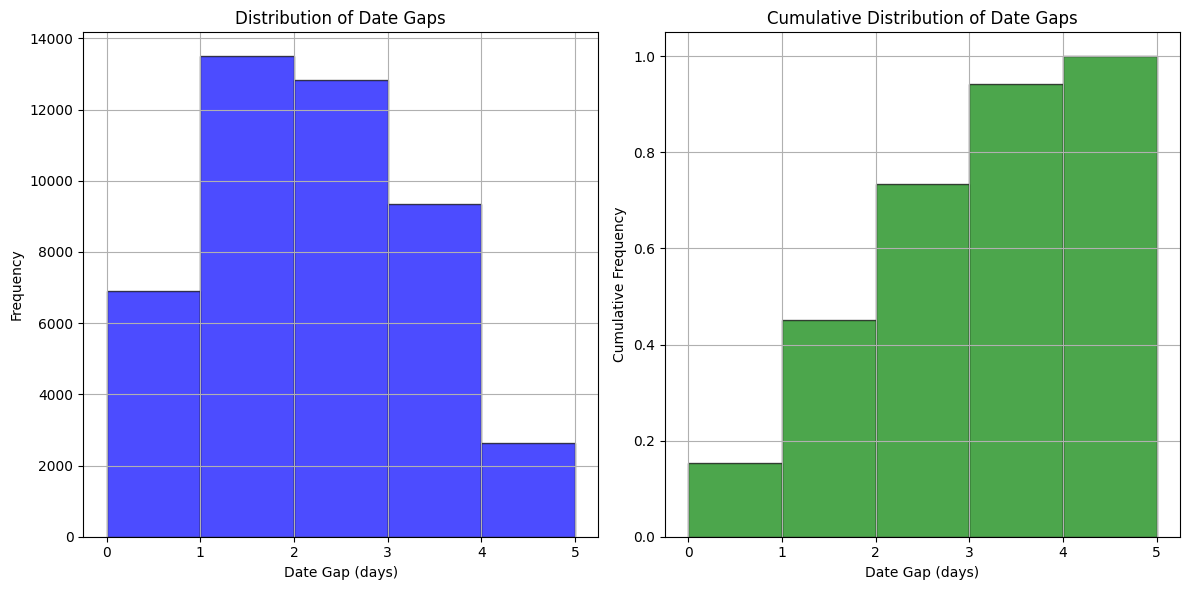

Average Date Utility Score: 0.449


0.4490179598336725

: 

: 

: 

: 

In [ ]:

visualize_date_gap(input_file, output_file)

In [487]:
def visualize_hour_gap(original_file, anonymized_file):
    """
    Visualize the impact of anonymization on hours and compute a utility score.
    
    Parameters:
        original_file (str): Path to the original dataset (non-anonymized).
        anonymized_file (str): Path to the anonymized dataset.
        
    Returns:
        float: The computed utility score for hour gaps.
    """
    # Load datasets
    original_data = pd.read_csv(original_file, delimiter="\t", names=["ID", "Date", "Latitude", "Longitude"])
    anonymized_data = pd.read_csv(anonymized_file, delimiter="\t", names=["AnonID", "AnonDate", "AnonLatitude", "AnonLongitude"])

    # Convert dates to datetime
    original_data["Date"] = pd.to_datetime(original_data["Date"], format="mixed")
    anonymized_data["AnonDate"] = pd.to_datetime(anonymized_data["AnonDate"], format="mixed")

    # Ensure datasets have the same number of rows
    if len(original_data) != len(anonymized_data):
        raise ValueError("The original and anonymized datasets must have the same number of rows.")

    # Compute hour gaps
    hour_gap = abs(original_data["Date"].dt.hour - anonymized_data["AnonDate"].dt.hour)

    # Plot distribution of hour gaps
    plt.figure(figsize=(12, 6))

    # Histogram of hour gaps
    plt.subplot(1, 2, 1)
    plt.hist(hour_gap, bins=range(0, 25), alpha=0.7, color="orange", edgecolor="black")
    plt.title("Distribution of Hour Gaps")
    plt.xlabel("Hour Gap")
    plt.ylabel("Frequency")
    plt.grid(True)

    # Cumulative distribution of hour gaps
    plt.subplot(1, 2, 2)
    plt.hist(hour_gap, bins=range(0, 25), alpha=0.7, color="green", edgecolor="black", cumulative=True, density=True)
    plt.title("Cumulative Distribution of Hour Gaps")
    plt.xlabel("Hour Gap")
    plt.ylabel("Cumulative Frequency")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Compute utility scores based on hour gaps
    hour_dec = [1, 0.9, 0.8, 0.6, 0.4, 0.2, 0, 0.1, 0.2, 0.3, 0.4, 0.5,
                0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0, 0.2, 0.4, 0.6, 0.8, 0.9]

    utility_scores = []
    for gap in hour_gap:
        if gap < len(hour_dec):
            utility_scores.append(1 - hour_dec[gap])
        else:
            utility_scores.append(0)  # Assign 0 utility if gap exceeds 24 hours (unlikely)

    # Calculate average utility score
    avg_utility = sum(utility_scores) / len(utility_scores)

    print(f"Average Hour Utility Score: {avg_utility:.3f}")

    return avg_utility



: 

: 

: 

: 

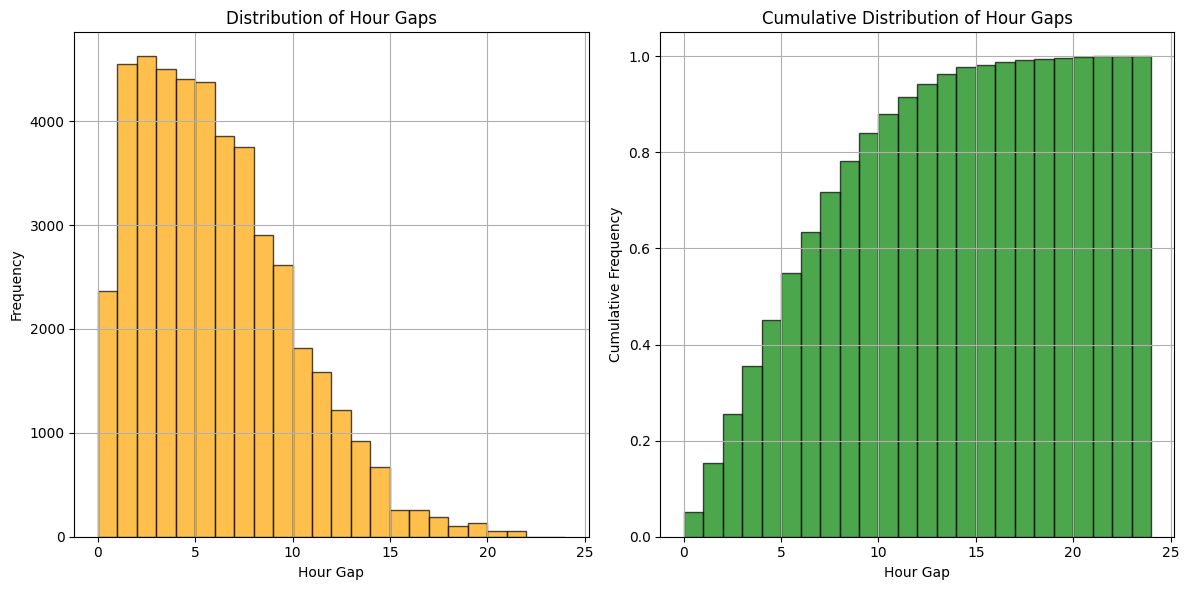

Average Hour Utility Score: 0.548


0.5477505971865877

: 

: 

: 

: 

In [488]:
visualize_hour_gap(input_file, output_file)

In [489]:
from math import radians, sin, cos, sqrt, atan2
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth (specified in decimal degrees).
    """
    # Earth radius in kilometers
    R = 6371.0

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

: 

: 

: 

: 

In [490]:
def visualize_distance_utility(original_file, anonymized_file, dx=0.1):
    """
    Visualize the impact of anonymization on GPS coordinates and compute a utility score.
    
    Parameters:
        input_file (str): Path to the original dataset (contains no headers).
        output_file (str): Path to the anonymized dataset (contains no headers).
        dx (float): Maximum allowed distance (in degrees, controls utility scoring).
    
    Returns:
        float: The computed average utility score for distance differences.
    """

    # Load datasets
    original_data = pd.read_csv(original_file, delimiter="\t", names=["ID", "Date", "Latitude", "Longitude"])
    anonymized_data = pd.read_csv(anonymized_file, delimiter="\t", names=["AnonID", "AnonDate", "AnonLatitude", "AnonLongitude"])

    # Convert data to numeric (handles potential string issues)
    original_data["Latitude"] = pd.to_numeric(original_data["Latitude"], errors="coerce")
    original_data["Longitude"] = pd.to_numeric(original_data["Longitude"], errors="coerce")
    anonymized_data["AnonLatitude"] = pd.to_numeric(anonymized_data["AnonLatitude"], errors="coerce")
    anonymized_data["AnonLongitude"] = pd.to_numeric(anonymized_data["AnonLongitude"], errors="coerce")

    # Drop rows with invalid (non-numeric) data
    original_data = original_data.dropna()
    anonymized_data = anonymized_data.dropna()

    # Ensure datasets have valid rows
    if original_data.empty or anonymized_data.empty:
        raise ValueError("No valid rows in the dataset after cleaning.")

    # Ensure datasets have the same number of rows
    if len(original_data) != len(anonymized_data):
        raise ValueError("The original and anonymized datasets must have the same number of rows after cleaning.")

    # Extract latitude and longitude values
    original_points = original_data[["Latitude", "Longitude"]].values
    anonymized_points = anonymized_data[["AnonLatitude", "AnonLongitude"]].values

    # Compute Euclidean distance differences
    distance_diff = np.sqrt(np.sum((original_points - anonymized_points) ** 2, axis=1))
    distance_diff = np.nan_to_num(distance_diff)  # Replace NaN with 0 in distance_diff

    # Calculate utility scores
    utility_scores = np.maximum(1 - distance_diff / dx, 0)  # Clamp to ensure no negative utilities
    avg_utility = np.mean(utility_scores)

    # Compute distances in kilometers using the Haversine formula
    distance_diff_km = [
        haversine(lat1, lon1, lat2, lon2)
        for (lat1, lon1), (lat2, lon2) in zip(original_points, anonymized_points)
    ]

    # Ensure avg_utility is not NaN
    if np.isnan(avg_utility):
        raise ValueError("Average utility score is NaN. Check your data and dx value.")

    # Plot distribution of distance differences (in kilometers)
    plt.figure(figsize=(12, 6))

    # Histogram of distance differences
    plt.subplot(1, 2, 1)
    plt.hist(distance_diff_km, bins=20, alpha=0.7, color="blue", edgecolor="black")
    plt.title("Distribution of Distance Differences (in km)")
    plt.xlabel("Distance Difference (km)")
    plt.ylabel("Frequency")
    plt.grid(True)

    # Cumulative distribution of distance differences
    plt.subplot(1, 2, 2)
    plt.hist(distance_diff_km, bins=20, alpha=0.7, color="green", edgecolor="black", cumulative=True, density=True)
    plt.title("Cumulative Distribution of Distance Differences (in km)")
    plt.xlabel("Distance Difference (km)")
    plt.ylabel("Cumulative Frequency")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot utility scores
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(utility_scores)), utility_scores, color="orange", alpha=0.7)
    plt.axhline(y=avg_utility, color="red", linestyle="--", label=f"Average Utility: {avg_utility:.3f}")
    plt.title("Utility Scores for Each Record")
    plt.xlabel("Record Index")
    plt.ylabel("Utility Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the average utility score
    print(f"Average Distance Utility Score: {avg_utility:.3f}")


: 

: 

: 

: 

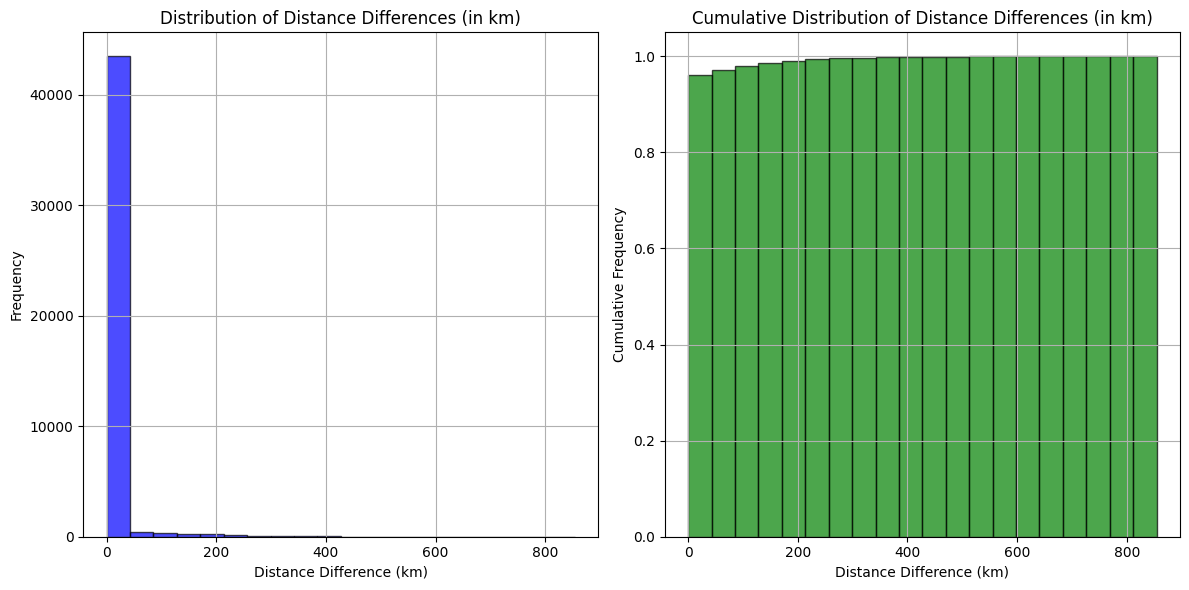

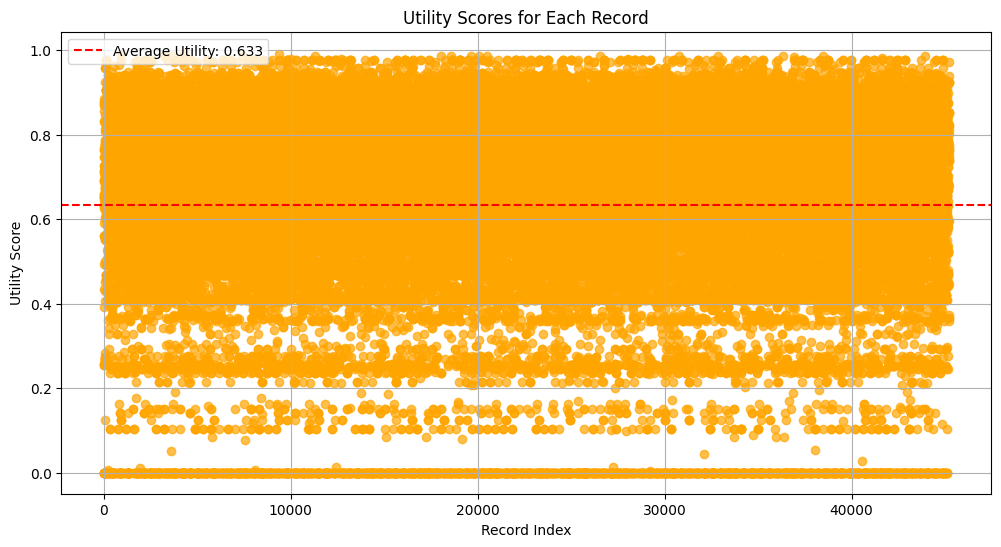

Average Distance Utility Score: 0.633


: 

: 

: 

: 

In [ ]:
visualize_distance_utility (input_file, output_file)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import matplotlib.ticker as ticker

def visualize_density_distribution(original_file, anonymized_file, size=2):
    """
    Visualize the density and distribution of GPS data for original and anonymized datasets.
    
    Parameters:
        original_file (str): Path to the original dataset.
        anonymized_file (str): Path to the anonymized dataset.
        size (int): Precision for rounding GPS coordinates to define cells.
    """
    # Load datasets
    original_data = pd.read_csv(original_file, delimiter="\t", names=["ID", "Date", "Latitude", "Longitude"])
    anonymized_data = pd.read_csv(anonymized_file, delimiter="\t", names=["AnonID", "AnonDate", "AnonLatitude", "AnonLongitude"])

    # Create cells by rounding coordinates
    original_data["Cell"] = original_data.apply(
        lambda row: (round(row["Latitude"], size), round(row["Longitude"], size)), axis=1
    )
    anonymized_data["Cell"] = anonymized_data.apply(
        lambda row: (round(row["AnonLatitude"], size), round(row["AnonLongitude"], size)), axis=1
    )

    # Count visits per cell
    original_visits = original_data.groupby("Cell").size().reset_index(name="Visits")
    anonymized_visits = anonymized_data.groupby("Cell").size().reset_index(name="Visits")

    # Split cell coordinates into latitude/longitude columns
    original_visits[["Latitude", "Longitude"]] = pd.DataFrame(original_visits["Cell"].tolist(), index=original_visits.index)
    anonymized_visits[["Latitude", "Longitude"]] = pd.DataFrame(anonymized_visits["Cell"].tolist(), index=anonymized_visits.index)

    plt.figure(figsize=(18, 6))

    # Original Data
    plt.subplot(1, 2, 1)
    sns.kdeplot(
        x=original_visits["Longitude"], 
        y=original_visits["Latitude"], 
        cmap="Blues", 
        fill=True, 
        thresh=0.05
    )
    plt.title("Original Data: Visit Density (KDE)")

    # Anonymized Data
    plt.subplot(1, 2, 2)
    ax = sns.kdeplot(
        x=anonymized_visits["Longitude"], 
        y=anonymized_visits["Latitude"], 
        cmap="Reds", 
        fill=True, 
        thresh=0.05
    )
    # Set the y-axis ticks with a specific interval
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

    plt.title("Anonymized Data: Visit Density (KDE)")
    plt.show()

: 

: 

: 

: 

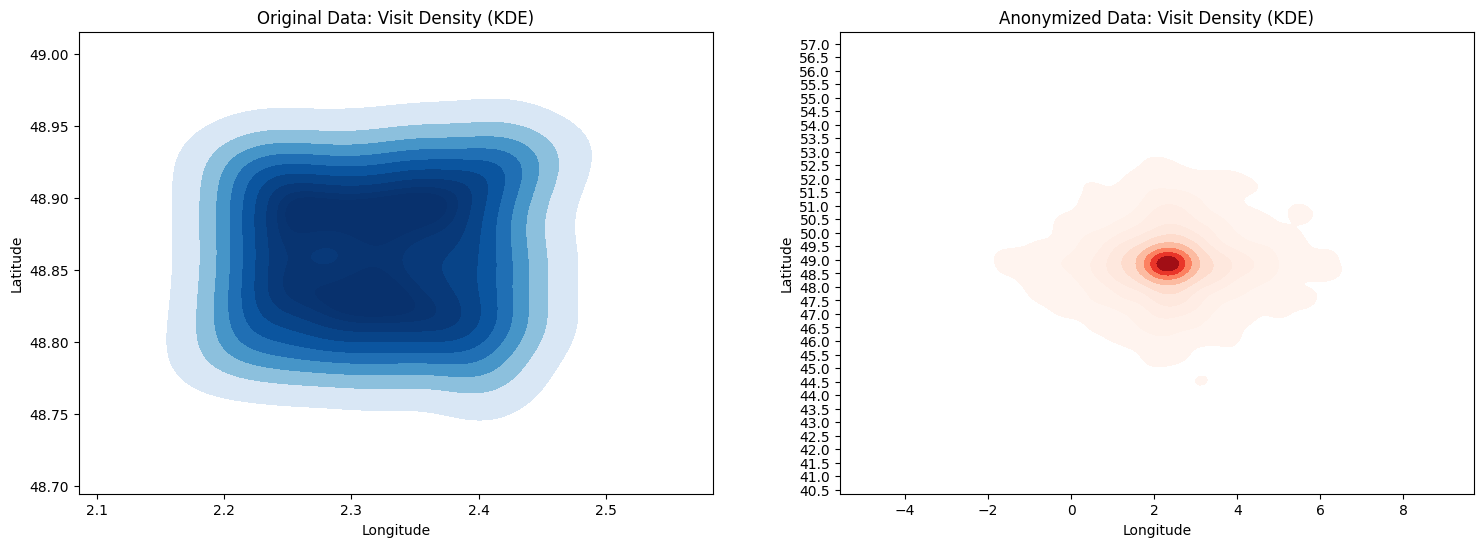

: 

: 

: 

: 

In [ ]:
visualize_density_distribution(input_file, output_file, size=2)